# Stock Price Prediction with LSTM-GRU-SimpleRNN

In [1]:
import numpy as np 
import pandas as pd 

In [7]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math

import warnings
warnings.filterwarnings("ignore")

In [34]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import seaborn as sns 

end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

stockname = 'Turkish Airlines'
symbol = 'THYAO.IS'

import yfinance as yf 
df = yf.download(symbol, start=start_date, end=end_date)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01 00:00:00+02:00,3.582293,3.582293,3.582293,3.582293,3.523511,0
2010-01-04 00:00:00+02:00,3.613994,3.677398,3.487188,3.645696,3.585874,11846086
2010-01-05 00:00:00+02:00,3.645696,3.677398,3.613994,3.645696,3.585874,7929532
2010-01-06 00:00:00+02:00,3.645696,3.677398,3.550591,3.613994,3.554692,9721300
2010-01-07 00:00:00+02:00,3.550591,3.582293,3.518889,3.550591,3.492329,7407485


In [35]:
# function which plots ibm stock prices: real and predicted both

def plot_predictions(test, predicted):
    plt.plot(test, color="red", label="real THYAO stock price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("THYAO stock price prediction")
    plt.xlabel("time")
    plt.ylabel("THYAO stock price")
    plt.legend()
    plt.show()

In [37]:
df.shape

(3375, 6)

In [38]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01 00:00:00+02:00,3.582293,3.582293,3.582293,3.582293,3.523511,0
2010-01-04 00:00:00+02:00,3.613994,3.677398,3.487188,3.645696,3.585874,11846086
2010-01-05 00:00:00+02:00,3.645696,3.677398,3.613994,3.645696,3.585874,7929532
2010-01-06 00:00:00+02:00,3.645696,3.677398,3.550591,3.613994,3.554692,9721300
2010-01-07 00:00:00+02:00,3.550591,3.582293,3.518889,3.550591,3.492329,7407485


In [39]:
train_df = df.sort_values(by=['Date']).copy()

FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            ,# 'Month' , 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-01-30 00:00:00+03:00,150.300003,144.800003,150.000000,144.800003,48666913,144.800003
2023-01-31 00:00:00+03:00,144.500000,137.600006,144.500000,137.600006,65737449,137.600006
2023-02-01 00:00:00+03:00,140.300003,130.800003,139.100006,130.800003,64560389,130.800003
2023-02-02 00:00:00+03:00,136.399994,125.099998,130.199997,134.600006,103057422,134.600006
2023-02-03 00:00:00+03:00,143.399994,133.199997,134.600006,142.699997,77657983,142.699997


In [40]:
nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(3375, 5)


In [41]:
np.set_printoptions(precision=3)

np_data = np.around(np_data, 3)

In [42]:
np_data[1]

array([3.677e+00, 3.487e+00, 3.614e+00, 3.646e+00, 1.185e+07])

In [43]:
np_data_scaled[0]

array([0.012, 0.012, 0.012, 0.012, 0.   ])

In [44]:
np_Close_scaled[0]

array([0.012])

In [45]:
sequence_length = 50

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2650, 50, 5) (2650,)
(675, 50, 5) (675,)
0.01081344028732197
0.01081344028732197


In [46]:
x_train[0]

array([[0.012, 0.012, 0.012, 0.012, 0.   ],
       [0.012, 0.012, 0.012, 0.012, 0.024],
       [0.012, 0.013, 0.012, 0.012, 0.016],
       [0.012, 0.012, 0.012, 0.012, 0.02 ],
       [0.012, 0.012, 0.012, 0.012, 0.015],
       [0.012, 0.012, 0.012, 0.011, 0.017],
       [0.011, 0.011, 0.012, 0.011, 0.022],
       [0.011, 0.011, 0.011, 0.011, 0.02 ],
       [0.011, 0.011, 0.011, 0.012, 0.027],
       [0.012, 0.012, 0.012, 0.012, 0.041],
       [0.012, 0.012, 0.012, 0.012, 0.015],
       [0.011, 0.012, 0.012, 0.012, 0.009],
       [0.012, 0.012, 0.012, 0.012, 0.016],
       [0.012, 0.012, 0.012, 0.012, 0.024],
       [0.011, 0.011, 0.012, 0.011, 0.019],
       [0.011, 0.011, 0.011, 0.011, 0.014],
       [0.011, 0.011, 0.011, 0.011, 0.01 ],
       [0.011, 0.011, 0.011, 0.012, 0.009],
       [0.012, 0.012, 0.011, 0.011, 0.021],
       [0.011, 0.011, 0.012, 0.011, 0.012],
       [0.011, 0.011, 0.011, 0.011, 0.011],
       [0.011, 0.011, 0.011, 0.012, 0.011],
       [0.011, 0.011, 0.012, 0.0

In [47]:
y_train[0]

0.01081344028732197

In [48]:
len(x_train)

2650

In [49]:
len(y_train)

2650

In [50]:
x_train.shape

(2650, 50, 5)

In [59]:
# LSTM architecture

regressor = Sequential()

# add first layer with dropout

regressor.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
regressor.add(Dropout(0.2))

# add second layer

regressor.add(LSTM(50, return_sequences=True))
regressor.add(Dropout(0.2))

# add third layer

regressor.add(LSTM(50, return_sequences=True))
regressor.add(Dropout(0.2))

# add fourth layer

regressor.add(LSTM(50))
regressor.add(Dropout(0.2))

# the output layer

regressor.add(Dense(1))

In [60]:
# compiling the LSTM RNN network

regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

# fit to the training set

regressor.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
83/83 [==============================] - 11s 56ms/step - loss: 3.5901e-04
Epoch 2/5
83/83 [==============================] - 5s 56ms/step - loss: 1.5864e-04
Epoch 3/5
83/83 [==============================] - 4s 54ms/step - loss: 1.0927e-04
Epoch 4/5
83/83 [==============================] - 5s 55ms/step - loss: 9.0163e-05
Epoch 5/5
83/83 [==============================] - 5s 56ms/step - loss: 7.5538e-05


In [63]:
# predicting the stock prices for test set

predicted = regressor.predict(x_test)
predicted = sc.inverse_transform(predicted)

22/22 [==============================] - 2s 20ms/step


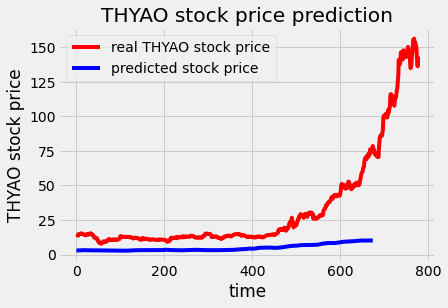

In [64]:
# visualizing the results: predicted vs test

plot_predictions(test, predicted)

In [68]:
y_pred_scaled = regressor.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(R2, 3)}')

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

22/22 [==============================] - 0s 19ms/step
R2: 0.677
Median Absolute Error (MAE): 9.63
Mean Absolute Percentage Error (MAPE): 13.05 %
Median Absolute Percentage Error (MDAPE): 7.96 %


Gated Recurrent Units

In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the output, .neither they have the output gate.

In [69]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

In [70]:
# compiling the model

regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

# fitting the model

regressorGRU.fit(x_train, y_train, epochs=5, batch_size=150)

Epoch 1/5
18/18 [==============================] - 9s 148ms/step - loss: 0.0016
Epoch 2/5
18/18 [==============================] - 3s 156ms/step - loss: 0.0011
Epoch 3/5
18/18 [==============================] - 3s 154ms/step - loss: 9.5053e-04
Epoch 4/5
18/18 [==============================] - 3s 138ms/step - loss: 8.9323e-04
Epoch 5/5
18/18 [==============================] - 3s 148ms/step - loss: 8.5113e-04


22/22 [==============================] - 2s 17ms/step


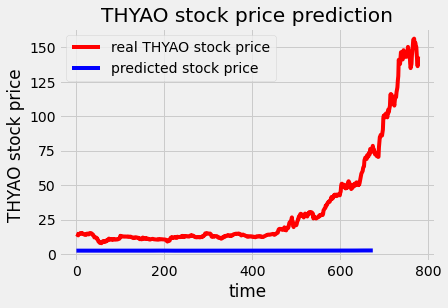

In [71]:
# predicting the stock prices for test set and visualization

predicted_with_gru = regressorGRU.predict(x_test)
predicted_with_gru = sc.inverse_transform(predicted_with_gru)

plot_predictions(test, predicted_with_gru)

In [73]:
y_pred_scaled = regressorGRU.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(R2, 3)}')

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

22/22 [==============================] - 0s 17ms/step
R2: -0.529
Median Absolute Error (MAE): 28.08
Mean Absolute Percentage Error (MAPE): 56.03 %
Median Absolute Percentage Error (MDAPE): 43.89 %
